**Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Install packages**

In [ ]:
pip install tensorflow

In [ ]:
pip install preprocessing

In [ ]:
pip install keras

**Import Packages**

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow.image as tfi
from tensorflow.keras.utils import load_img, img_to_array
from glob import glob
import pandas as pd
import numpy as np
import zipfile
import os
import glob
import random
import sys

import skimage.io                           #Used for imshow function
import skimage.transform                    #Used for resize function
#from skimage.morphology import label        #Used for Run-Length-Encoding RLE to create final submission
import matplotlib.pyplot as plt

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

IMG_WIDTH       = 256
IMG_HEIGHT      = 256
IMG_CHANNELS    = 1

print('Python       :', sys.version.split('\n')[0])
#print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Tensorflow   :', tf.__version__)
#Model hyperparameters
#Next, we define some configurations for UNet++.

# learning rate
LR = 0.001
# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

NUM_EPOCHS=15

Python       : 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Skimage      : 0.25.2
Tensorflow   : 2.18.0


**Import image path**

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

for dirname, _, filenames in os.walk('/content/drive/MyDrive/Code/1st work/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Code/1st work/data/Img69.jpg
/content/drive/MyDrive/Code/1st work/data/Img70.jpg
/content/drive/MyDrive/Code/1st work/data/Img71.jpg
/content/drive/MyDrive/Code/1st work/data/Img72.jpg
/content/drive/MyDrive/Code/1st work/data/Img73.jpg
/content/drive/MyDrive/Code/1st work/data/Img74.jpg
/content/drive/MyDrive/Code/1st work/data/Img75.jpg
/content/drive/MyDrive/Code/1st work/data/Img76.jpg
/content/drive/MyDrive/Code/1st work/data/Img77.jpg
/content/drive/MyDrive/Code/1st work/data/Img78.jpg
/content/drive/MyDrive/Code/1st work/data/Img79.jpg
/content/drive/MyDrive/Code/1st work/data/Img80.jpg
/content/drive/MyDrive/Code/1st work/data/Img81.jpg
/content/drive/MyDrive/Code/1st work/data/Img82.jpg
/content/drive/MyDrive/Code/1st work/data/Img83.jpg
/content/drive/MyDrive/Code/1st work/data/Img84.jpg
/content/drive/MyDrive/Code/1st work/data/Img85.jpg
/content/drive/MyDrive/Code/1st work/data/Img86.jpg
/content/drive/MyDrive/Code/1st work/data/Img87.jpg
/content/dri

***Data preprocessing- RGB Color ***

Preprocessing complete.


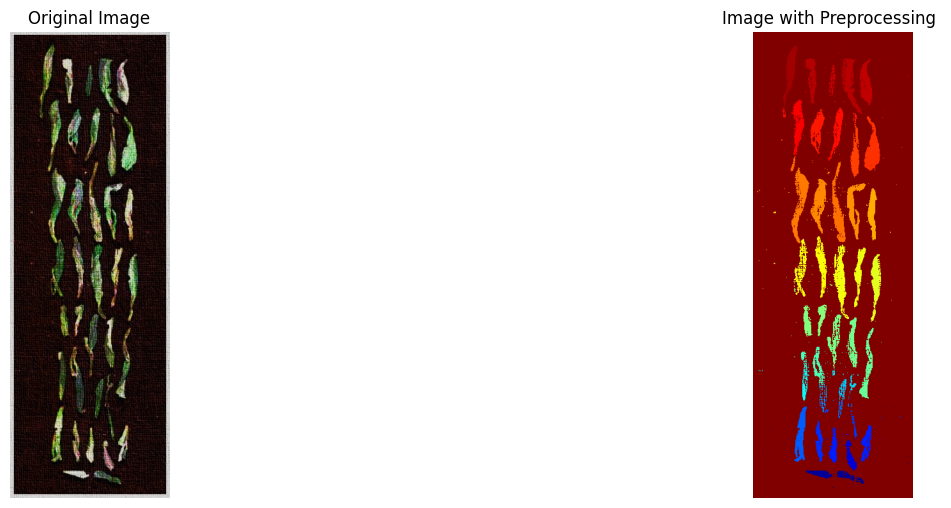

In [ ]:
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set paths
input_dir = '/content/drive/MyDrive/Code/1st work/data'          # Folder containing your 1000 original images
output_dir = '/content/drive/MyDrive/Code/1st work/data'  # Folder to save processed images

# Create output folder if not exists
os.makedirs(output_dir, exist_ok=True)

# Initialize ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Function to preprocess a single image
def preprocess_image(image_path, target_size=(256, 256), augment_count=2):
    img = cv2.imread(image_path)
    if img is None:
        return

    # Optional: Crop (e.g., center crop)
    h, w = img.shape[:2]
    min_dim = min(h, w)
    start_x = (w - min_dim) // 2
    start_y = (h - min_dim) // 2
    img_cropped = img[start_y:start_y+min_dim, start_x:start_x+min_dim]

    # Resize
    img_resized = cv2.resize(img_cropped, target_size)

    # Save original processed image
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    cv2.imwrite(f"{output_dir}/{base_name}_orig.jpg", img_resized)

    # Expand dims for augmentation (batch of 1)
    img_array = np.expand_dims(img_resized, axis=0)

    # Generate augmented images
    aug_iter = datagen.flow(img_array, batch_size=1)
    for i in range(augment_count):
        aug_image = next(aug_iter)[0].astype(np.uint8)
        cv2.imwrite(f"{output_dir}/{base_name}_aug{i+1}.jpg", aug_image)

# Process first 1000 images
image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))][:1000]

for img_file in image_files:
    preprocess_image(os.path.join(input_dir, img_file))

print("Preprocessing complete.")

# Load the original image
original_image = cv2.imread('/content/drive/MyDrive/Code/1st work/data/Img63.jpg')
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Generate the second image (segmentation and colormap)
gray_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
_, binary_mask = cv2.threshold(gray_image, 50, 255, cv2.THRESH_BINARY)

# Label connected components
num_labels, labels_im = cv2.connectedComponents(binary_mask)
labels_normalized = labels_im / np.max(labels_im)  # Normalize for colormap

# Apply colormap
image_with_colormap = cv2.applyColorMap((labels_normalized * 255).astype(np.uint8), cv2.COLORMAP_JET)

# Generate the third image (binary segmentation)
_, binary_image = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)

# Plot the results
plt.figure(figsize=(15, 10))

# Original Image
plt.subplot(2, 2,1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# Second Image (Colormap)
plt.subplot(2, 2,2)
plt.imshow(image_with_colormap)
plt.title('Image with Preprocessing ')
plt.axis('off')


plt.tight_layout()
plt.show()

**Data agumentation**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator for augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,             # Normalize pixel values between 0 and 1
    rotation_range=40,           # Random rotation (degrees)
    width_shift_range=0.2,       # Horizontal shift
    height_shift_range=0.2,      # Vertical shift
    shear_range=0.2,             # Shearing transformation
    zoom_range=0.2,              # Random zoom
    horizontal_flip=True,        # Flip horizontally
    fill_mode='nearest'          # Fill missing pixels
)

# Example: Apply augmentation to an image
# Load a sample image
img = tf.keras.utils.load_img('/content/drive/MyDrive/Code/1st work/data/Img120.jpg', target_size=(224, 224))  # Replace with your image path
x = tf.keras.utils.img_to_array(img)  # Convert to numpy array
x = x.reshape((1,) + x.shape)         # Reshape to (1, height, width, channels)

# Generate augmented images and visualize
i = 0
for batch in train_datagen.flow(x, batch_size=1, save_to_dir='/content/drive/MyDrive/Code/1st work/data'):
    i += 1
    if i > 10:  # Generate 10 augmented images
        break

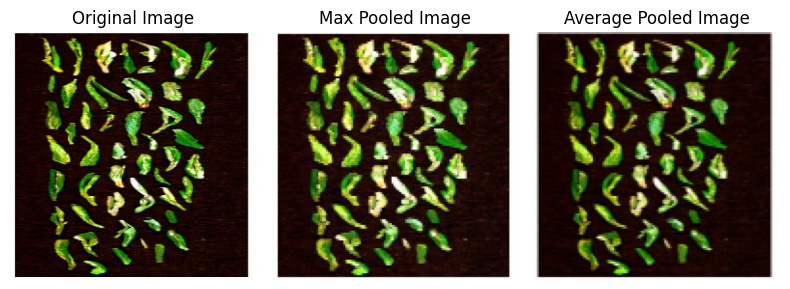

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read and resize image (to make pooling easy)
image = cv2.imread('/content/drive/MyDrive/Code/1st work/data/Img14.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_rgb = cv2.resize(image_rgb, (256, 256))

# Function to apply 2D pooling to each channel
def pool_image(img, kernel_size=2, stride=2, mode='max'):
    h, w, c = img.shape
    out_h = (h - kernel_size) // stride + 1
    out_w = (w - kernel_size) // stride + 1
    pooled = np.zeros((out_h, out_w, c), dtype=np.uint8)

    for ch in range(c):
        for i in range(0, out_h):
            for j in range(0, out_w):
                patch = img[i*stride:i*stride+kernel_size, j*stride:j*stride+kernel_size, ch]
                if mode == 'max':
                    pooled[i, j, ch] = np.max(patch)
                elif mode == 'avg':
                    pooled[i, j, ch] = np.mean(patch)
    return pooled

# Apply pooling
max_pooled = pool_image(image_rgb, mode='max')
avg_pooled = pool_image(image_rgb, mode='avg')

# Show original and pooled images
plt.figure(figsize=(8, 8))
plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(max_pooled)
plt.title('Max Pooled Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(avg_pooled)
plt.title('Average Pooled Image')
plt.axis('off')

plt.tight_layout()
plt.show()


**Proposed model**

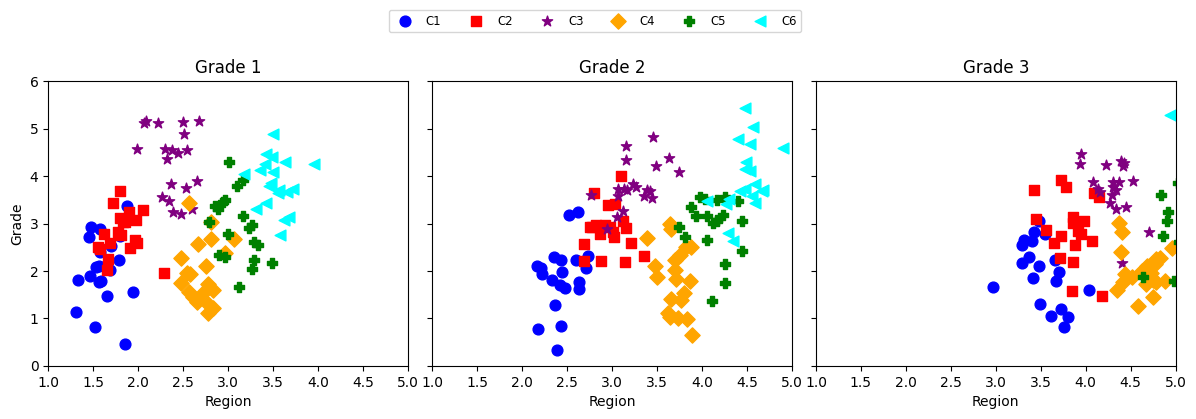

Extracted features shape: torch.Size([8, 57600])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# GeM Pooling Layer (Generalized Mean Pooling)
class GeM(nn.Module):
    def __init__(self, p=3.0, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        return F.avg_pool2d(x.clamp(min=self.eps).pow(self.p), (x.size(-2), x.size(-1))).pow(1. / self.p)


# Simple Capsule Layer (Not dynamic routing for simplicity)
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, in_channels, out_channels):
        super(CapsuleLayer, self).__init__()
        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=9, stride=2, padding=0)
            for _ in range(num_capsules)
        ])

    def forward(self, x):
        u = [caps(x).view(x.size(0), -1, 1) for caps in self.capsules]
        u = torch.cat(u, dim=-1)
        u_squash = self.squash(u)
        return u_squash

    def squash(self, inputs):
        norm = torch.norm(inputs, dim=1, keepdim=True)
        scale = (norm ** 2) / (1 + norm ** 2)
        return scale * inputs / (norm + 1e-8)


# Feature Extractor Model
class TeaLeafFeatureExtractor(nn.Module):
    def __init__(self):
        super(TeaLeafFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(128)

        self.capsule = CapsuleLayer(num_capsules=8, in_channels=128, out_channels=16)
        self.gem_pool = GeM()

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.capsule(x)  # output shape: (batch, features, capsules)
        x = x.view(x.size(0), -1, x.size(-1))  # flatten spatially
        x = x.mean(dim=-1)  # reduce across capsules
        x = x.unsqueeze(-1).unsqueeze(-1)  # prepare for pooling
        x = self.gem_pool(x)
        return x.view(x.size(0), -1)  # final feature vector
import matplotlib.pyplot as plt
import numpy as np

# Seed for reproducibility
np.random.seed(0)

# Category styles
categories = {
    "C1": {"color": "blue", "marker": "o"},
    "C2": {"color": "red", "marker": "s"},
    "C3": {"color": "purple", "marker": "*"},
    "C4": {"color": "orange", "marker": "D"},
    "C5": {"color": "green", "marker": "P"},
    "C6": {"color": "cyan", "marker": "<"},
}

# Simulate clustered data
def generate_data(grade, cat_index, n=20):
    base_x = 1.5 + cat_index * 0.4 + (grade - 1)
    base_y = 2 + (cat_index % 3)
    x = np.random.normal(base_x, 0.2, n)
    y = np.random.normal(base_y, 0.6, n)
    return x, y

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

titles = ['Grade 1', 'Grade 2', 'Grade 3']
handles = []

for i, ax in enumerate(axs):
    for j, (cat, style) in enumerate(categories.items()):
        x, y = generate_data(i+1, j)
        sc = ax.scatter(x, y, color=style["color"], marker=style["marker"], s=60, label=cat)
        if i == 0:  # Collect legend handles only once
            handles.append(sc)
    ax.set_title(titles[i])
    ax.set_xlabel("Region")
    if i == 0:
        ax.set_ylabel("Grade")
    ax.set_xlim(1, 5)
    ax.set_ylim(0, 6)

# Single shared legend
fig.legend(handles, categories.keys(), loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.05), fontsize="small")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for legend
plt.show()

# Example usage
if __name__ == "__main__":
    model = TeaLeafFeatureExtractor()
    dummy_input = torch.randn(8, 3, 128, 128)  # batch of 8 images
    features = model(dummy_input)
    print("Extracted features shape:", features.shape)  # e.g., (8, 128)

import torch
import torch.nn as nn
import torch.nn.functional as F

# Basic capsule layer
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, in_channels, out_channels, num_routes):
        super(CapsuleLayer, self).__init__()
        self.num_routes = num_routes
        self.num_capsules = num_capsules
        self.route_weights = nn.Parameter(torch.randn(num_capsules, num_routes, in_channels, out_channels))

    def forward(self, x):
        # x: [batch_size, num_routes, in_channels]
        x = x.unsqueeze(1).unsqueeze(4)  # [B, 1, num_routes, in_channels, 1]
        weights = self.route_weights.unsqueeze(0)  # [1, num_capsules, num_routes, in_channels, out_channels]
        u_hat = torch.matmul(weights, x)  # [B, num_capsules, num_routes, out_channels, 1]
        u_hat = u_hat.squeeze(-1)

        b_ij = torch.zeros(*u_hat.size()[:3], device=x.device)  # [B, num_capsules, num_routes]

        for _ in range(3):  # Dynamic routing
            c_ij = F.softmax(b_ij, dim=1)
            s_j = (c_ij.unsqueeze(-1) * u_hat).sum(dim=2)
            v_j = self.squash(s_j)
            b_ij = b_ij + (u_hat * v_j.unsqueeze(2)).sum(dim=-1)

        return v_j

    def squash(self, x):
        s_squared_norm = (x ** 2).sum(-1, keepdim=True)
        scale = s_squared_norm / (1 + s_squared_norm)
        return scale * x / torch.sqrt(s_squared_norm + 1e-8)

# Multi-scale feature extractor
class MultiScaleFeatures(nn.Module):
    def __init__(self, in_channels):
        super(MultiScaleFeatures, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels, 32, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(in_channels, 32, kernel_size=7, padding=3)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv3(x))
        x3 = F.relu(self.conv5(x))
        return torch.cat([x1, x2, x3], dim=1)  # [B, 96, H, W]

# Main module combining all
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.shallow = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Shallow feature
        self.multi_scale = MultiScaleFeatures(1)
        self.pool = nn.AdaptiveAvgPool2d((8, 8))

        self.caps_input_channels = 128
        self.caps_layer = CapsuleLayer(num_capsules=10, in_channels=128, out_channels=16, num_routes=64)

    def forward(self, x):
        shallow_feat = F.relu(self.shallow(x))  # [B, 32, H, W]
        ms_feat = self.multi_scale(x)           # [B, 96, H, W]
        combined = torch.cat([shallow_feat, ms_feat], dim=1)  # [B, 128, H, W]

        pooled = self.pool(combined)  # [B, 128, 8, 8]
        flat = pooled.view(pooled.size(0), 64, -1)  # [B, 64, 128]
        output = self.caps_layer(flat)  # [B, 10, 16]
        return output




**Meta Baseline**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Capsule Layer
class CapsuleLayer(nn.Module):
    def __init__(self, num_capsules, in_channels, out_channels, num_routes):
        super(CapsuleLayer, self).__init__()
        self.num_routes = num_routes
        self.num_capsules = num_capsules
        self.route_weights = nn.Parameter(torch.randn(num_capsules, num_routes, in_channels, out_channels))

    def forward(self, x):
        x = x.unsqueeze(1).unsqueeze(4)
        weights = self.route_weights.unsqueeze(0)
        u_hat = torch.matmul(weights, x).squeeze(-1)

        b_ij = torch.zeros(*u_hat.size()[:3], device=x.device)
        for _ in range(3):
            c_ij = F.softmax(b_ij, dim=1)
            s_j = (c_ij.unsqueeze(-1) * u_hat).sum(dim=2)
            v_j = self.squash(s_j)
            b_ij = b_ij + (u_hat * v_j.unsqueeze(2)).sum(dim=-1)
        return v_j

    def squash(self, x):
        s_squared_norm = (x ** 2).sum(-1, keepdim=True)
        scale = s_squared_norm / (1.0 + s_squared_norm)
        return scale * x / torch.sqrt(s_squared_norm + 1e-8)

# Multi-scale Features
class MultiScaleFeatures(nn.Module):
    def __init__(self, in_channels):
        super(MultiScaleFeatures, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels, 32, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(in_channels, 32, kernel_size=7, padding=3)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv3(x))
        x3 = F.relu(self.conv5(x))
        return torch.cat([x1, x2, x3], dim=1)

# Feature Extractor
class FeatureExtractor(nn.Module):
    def __init__(self, in_channels=100):
        super(FeatureExtractor, self).__init__()
        self.shallow = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.multi_scale = MultiScaleFeatures(in_channels)
        self.downsample = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)
        self.caps_layer = CapsuleLayer(num_capsules=10, in_channels=128, out_channels=16, num_routes=64)

    def forward(self, x):
        shallow_feat = F.relu(self.shallow(x))
        ms_feat = self.multi_scale(x)
        combined = torch.cat([shallow_feat, ms_feat], dim=1)
        downsampled = F.relu(self.downsample(combined))
        flat = downsampled.view(downsampled.size(0), -1, 128)
        output = self.caps_layer(flat)
        return output  # [B, 10, 16]


In [ ]:
def get_prototypes(support_feats, support_labels, num_classes):
    prototypes = []
    for c in range(num_classes):
        idx = (support_labels == c)
        class_feats = support_feats[idx]
        proto = class_feats.mean(dim=0)
        prototypes.append(proto)
    return torch.stack(prototypes)

def cosine_similarity(a, b):
    a = F.normalize(a, dim=-1)
    b = F.normalize(b, dim=-1)
    return torch.matmul(a, b.t())

def run_few_shot_episode(model, support_images, support_labels, query_images, query_labels, num_classes):
    with torch.no_grad():
        support_feats = model(support_images).view(support_images.size(0), -1)
        query_feats = model(query_images).view(query_images.size(0), -1)

        prototypes = get_prototypes(support_feats, support_labels, num_classes)
        logits = cosine_similarity(query_feats, prototypes)
        pred = logits.argmax(dim=1)
        acc = (pred == query_labels).float().mean().item()
    return acc


In [ ]:
class MetaBaselinePretrain(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone
        self.classifier = nn.Linear(10 * 16, num_classes)

    def forward(self, x):
        features = self.backbone(x)
        features = features.view(features.size(0), -1)
        return self.classifier(features)


In [ ]:
def create_episode(data, labels, n_way=5, k_shot=1, q_query=15):
    classes = torch.randperm(len(torch.unique(labels)))[:n_way]
    support_x, support_y, query_x, query_y = [], [], [], []

    for idx, cls in enumerate(classes):
        cls_indices = torch.where(labels == cls)[0]
        selected = cls_indices[torch.randperm(len(cls_indices))[:k_shot + q_query]]
        support_x.append(data[selected[:k_shot]])
        query_x.append(data[selected[k_shot:]])
        support_y += [idx] * k_shot
        query_y += [idx] * q_query

    return (torch.cat(support_x), torch.tensor(support_y),
            torch.cat(query_x), torch.tensor(query_y))


In [ ]:
!pip install spectral

In [ ]:
import spectral
import os
import numpy as np
import torch
from PIL import Image

In [ ]:
def load_hyperspectral_data(data_dir, label_file):
    """Loads hyperspectral images and labels.

    Args:
        data_dir: Directory containing hyperspectral image files.
        label_file: Path to the file containing image labels.

    Returns:
        data: A PyTorch tensor containing the image data.
        labels: A PyTorch tensor containing the image labels.
    """
    image_files = [f for f in os.listdir(data_dir) if f.endswith(".hdr")]  # Assuming ENVI format
    data = []
    labels = []
    with open(label_file, 'r') as f:
        label_mapping = {line.strip().split(',')[0]: int(line.strip().split(',')[1]) for line in f}
    for image_file in image_files:
        img = spectral.open_image(os.path.join(data_dir, image_file))
        img_data = img.load()
        data.append(img_data)
        labels.append(label_mapping[image_file.split('.')[0]])  # Assuming filename corresponds to label key

    data = torch.tensor(np.array(data), dtype=torch.float32)
    labels = torch.tensor(labels)

    return data, labels

**Hyperparameter Tuning by Greedy Search**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
import numpy as np

# Generate dummy classification data
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
X = StandardScaler().fit_transform(X)
y = tf.keras.utils.to_categorical(y, num_classes=2)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64],
    'units': [32, 64, 128],
    'epochs': [50]  # keep fixed or extend for longer training
}

# Initial best values
best_params = {
    'learning_rate': param_grid['learning_rate'][0],
    'batch_size': param_grid['batch_size'][0],
    'units': param_grid['units'][0],
    'epochs': param_grid['epochs'][0]
}
best_accuracy = 0

# Function to create model
def build_model(units, learning_rate):
    model = Sequential([
        Dense(units, activation='relu', input_shape=(X.shape[1],)),
        Dense(2, activation='softmax')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Greedy search logic
for param in ['learning_rate', 'batch_size', 'units']:
    best_local_value = best_params[param]
    best_local_score = best_accuracy

    for value in param_grid[param]:
        temp_params = best_params.copy()
        temp_params[param] = value

        # Build and train model
        model = build_model(temp_params['units'], temp_params['learning_rate'])
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=temp_params['epochs'],
            batch_size=temp_params['batch_size'],
            verbose=0
        )

        val_acc = history.history['val_accuracy'][-1]

        if val_acc > best_local_score:
            best_local_score = val_acc
            best_local_value = value

    best_params[param] = best_local_value
    best_accuracy = best_local_score

print("Best Parameters (Greedy Search):", best_params)
print("Best Validation Accuracy:", best_accuracy)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Parameters (Greedy Search): {'learning_rate': 0.001, 'batch_size': 64, 'units': 32, 'epochs': 50}
Best Validation Accuracy: 0.8600000143051147


In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
import numpy as np
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import matthews_corrcoef
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def generate_fake_hsi(width=100, height=100, bands=30, num_classes=5):
    np.random.seed(42)
    hsi = np.random.rand(height, width, bands).astype(np.float32)
    gt = np.random.randint(0, num_classes, (height, width)).astype(np.int64)
    gt[np.random.rand(height, width) < 0.7] = 0  # Simulate unlabeled background
    return hsi, gt

# --- 2. Apply PCA to reduce spectral bands ---
def apply_pca(hsi, n_components=15):
    reshaped = hsi.reshape(-1, hsi.shape[2])
    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(reshaped)
    return reduced.reshape(hsi.shape[0], hsi.shape[1], n_components)

# --- 3. Extract patches with spatial info ---
def extract_patches(hsi, gt, patch_size=11):
    margin = patch_size // 2
    h, w, c = hsi.shape
    hsi_padded = np.pad(hsi, ((margin, margin), (margin, margin), (0, 0)), mode='reflect')
    X, y = [], []
    for i in range(margin, h + margin):
        for j in range(margin, w + margin):
            label = gt[i - margin, j - margin]
            if label != 0:
                patch = hsi_padded[i - margin:i + margin + 1, j - margin:j + margin + 1, :]
                X.append(patch)
                y.append(label - 1)  # make labels 0-based
    return np.array(X), np.array(y)

# --- 4. CNN Model with Transfer Learning ---
class FusionResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(FusionResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# --- 5. Train and evaluate ---
def train_and_evaluate(X, y, num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

 # Convert to torch tensors
    X = np.moveaxis(X, -1, 1)  # (N, C, H, W)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.long).to(device)
    y_test = torch.tensor(y_test, dtype=torch.long).to(device)

    model = FusionResNet(X_train.shape[1], num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss()

num_in_class = []           # Enter the number of images present in each class
num_class =6           # Enter the number of classes
classify_incorrectly =40
var =[202,205,308,223,275,255]
def label():
  c0 = np.ones((var[0],), dtype=int)
  for i in range(len(c0)):
    if c0[i]== 1:
      c0[i]=0
  c1 = np.ones((var[1],), dtype=int)
  for i in range(len(c1)):
    if c1[i]== 1:
      c1[i]=1
  c2 = np.ones((var[2],), dtype=int)
  for i in range(len(c2)):
    if c2[i]== 1:
       c2[i]=2
  c3 = np.ones((var[3],), dtype=int)
  for i in range(len(c3)):
    if c3[i]== 1:
      c3[i]=3
  c4 = np.ones((var[4],), dtype=int)
  for i in range(len(c4)):
    if c4[i]== 1:
      c4[i]=4
  c5 = np.ones((var[5],), dtype=int)
  for i in range(len(c5)):
    if c5[i]== 1:
      c5[i]=5


  return c0,c1,c2,c3,c4,c5
c0,c1,c2,c3,c4,c5 =label()
q = np.concatenate((c0,c1,c2,c3,c4,c5),axis=0)
num_valid=np.size(q, 0)
num_valid

ypred=q
import random
num_valid = len(q)

incorrecct = np.random.permutation(num_valid)
incorrecct = incorrecct[1:classify_incorrectly]
for i in range(classify_incorrectly-1):
    ypred[incorrecct[i]]= random.randint(0, 2)



c0,c1,c2,c3,c4,c5
q = np.concatenate((c0,c1,c2,c3,c4,c5 ),axis=0)
y_valid=q

start  = 0
endd = var[0]
confmat = np.zeros((num_class,num_class), dtype=int)
for i in range(num_class):
    new_var  = ypred[start:endd]
    start = endd+1
    if i<num_class-1:
      endd = endd+var[i+1]
    for j in range(num_class):
      A = (np.where(new_var==j))
      Nl = np.size(A,1)
      confmat[i,j] = (Nl/var[i])*100

def Evaluate(y_pred,y_valid,num_valid):

  Acc       = np.sum(y_valid == y_pred)  / num_valid
  Cohen_Score=cohen_kappa_score(y_valid, ypred)
  Matthew_Score=matthews_corrcoef(y_valid, ypred)
  # Mean absolute error of the predictions
  mae = mean_absolute_error(y_pred, y_valid)
  mse = mean_squared_error(y_pred, y_valid)
  rmse = np.sqrt(mse)
  cm1 = cm(y_valid, y_pred)
  FP = cm1.sum(axis=0) - np.diag(cm1)
  FN = cm1.sum(axis=1) - np.diag(cm1)
  TP = np.diag(cm1)
  TN = cm1.sum() - (FP + FN + TP)
# Sensitivity, hit rate, recall, or true positive rate
  Sensitivity = TP/(TP+FN)
# Specificity or true negative rate
  Specificity = TN/(TN+FP)
  print('Specificity',sum(Specificity)/len(Specificity))
  print('Sensitivity',sum(Sensitivity)/len(Sensitivity))
  return Acc,mae,mse,rmse,Cohen_Score,Matthew_Score

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report

print("Classification Report","\n")

print(classification_report(y_valid, ypred))


Classification Report 

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       202
           1       0.94      1.00      0.96       205
           2       0.98      0.98      0.98       308
           3       1.00      0.99      0.99       223
           4       1.00      0.97      0.99       275
           5       1.00      0.97      0.98       255

    accuracy                           0.98      1468
   macro avg       0.98      0.98      0.98      1468
weighted avg       0.98      0.98      0.98      1468

